In [16]:
import numpy as np,pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras.layers import *
from keras.models import *
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
import os, shutil
import warnings
import bs4
from bs4 import BeautifulSoup
from urllib.parse import urljoin
from keras.optimizers import Adam
warnings.filterwarnings('ignore')
import requests
from io import BytesIO
from PIL import Image
import mimetypes
import random

In [2]:
#資料路徑
train='C:\\cin\\Vegetable Images\\train'
validation='C:\\cin\\Vegetable Images\\validation'
test ='C:\\cin\\Vegetable Images\\test'

In [34]:
class_map = dict([(v, k) for k, v in train_image_generator.class_indices.items()])

In [3]:
#正規化資料
#train
train_gen = ImageDataGenerator(rescale = 1.0/255.0)
train_image_generator = train_gen.flow_from_directory(
                                            train,
                                            target_size=(150, 150),
                                            batch_size=32,
                                            class_mode='categorical')

#validation
val_gen = ImageDataGenerator(rescale = 1.0/255.0)
val_image_generator = train_gen.flow_from_directory(
                                            validation,
                                            target_size=(150, 150),
                                            batch_size=32,
                                            class_mode='categorical')

#Test
test_gen = ImageDataGenerator(rescale = 1.0/255.0)
test_image_generator = train_gen.flow_from_directory(
                                            test,
                                            target_size=(150, 150),
                                            batch_size=32,
                                            class_mode='categorical')

Found 14000 images belonging to 14 classes.
Found 2800 images belonging to 14 classes.
Found 2800 images belonging to 14 classes.


In [30]:
#建立CNN模型
model = Sequential()

model.add(Conv2D(filters=32, kernel_size=3, strides=1, padding='same', activation='relu', input_shape=[150, 150, 3]))
model.add(MaxPooling2D(2))
model.add(Conv2D(filters=64, kernel_size=3, strides=1, padding='same', activation='relu'))
model.add(Flatten())

#全連接層
model.add(Dropout(0.25))
model.add(Dense(128, activation='relu'))
model.add(Dense(14, activation='softmax'))

#summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 150, 150, 32)      896       
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 75, 75, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 75, 75, 64)        18496     
                                                                 
 flatten_1 (Flatten)         (None, 360000)            0         
                                                                 
 dropout_1 (Dropout)         (None, 360000)            0         
                                                                 
 dense_2 (Dense)             (None, 128)               46080128  
                                                      

In [41]:
#資料集匯入建立好的模型訓練
early_stopping = keras.callbacks.EarlyStopping(patience=3) 
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics='accuracy')
model.fit(train_image_generator, 
                 epochs=5, 
                 verbose=1,
                 validation_data=val_image_generator, 
                 steps_per_epoch = 8000//32, 
                 validation_steps = 1500//32,
                 callbacks=early_stopping)

Epoch 1/5
250/250 [==============================] - 216s 857ms/step - loss: 0.1050 - accuracy: 0.9698 - val_loss: 0.4661 - val_accuracy: 0.8899
Epoch 2/5
250/250 [==============================] - 222s 887ms/step - loss: 0.0666 - accuracy: 0.9798 - val_loss: 0.4395 - val_accuracy: 0.9008
Epoch 3/5
250/250 [==============================] - 227s 908ms/step - loss: 0.0226 - accuracy: 0.9934 - val_loss: 0.5591 - val_accuracy: 0.8791
Epoch 4/5
250/250 [==============================] - 264s 1s/step - loss: 0.0332 - accuracy: 0.9902 - val_loss: 0.5847 - val_accuracy: 0.8662
Epoch 5/5
250/250 [==============================] - 288s 1s/step - loss: 0.0564 - accuracy: 0.9833 - val_loss: 0.6191 - val_accuracy: 0.8641


In [33]:
#準確率測試
model.evaluate(test_image_generator)

88/88 [==============================] - 36s 411ms/step - loss: 0.6038 - accuracy: 0.8050


[0.6038379669189453, 0.8050000071525574]

In [20]:
#爬蟲取得營養成分表
def VegetableName(predicted_vegetable):
    Vlist = []
    url = f"https://consumer.fda.gov.tw/Food/TFND.aspx?nodeID=178&t=5&k={predicted_vegetable}"
    resp = requests.request("get",url)
    resp.encoding = "utf-8"
    soup = BeautifulSoup(resp.text,"html.parser")
    nodes = soup.select("table > tbody > tr:nth-child(2) > td:nth-child(3) > a")
    
    V_list = [urljoin(url, node.get("href")) for node in nodes]

    #----------------
    url = V_list[0]
    resp = requests.get(""+url)
    soup = BeautifulSoup(resp.content, "html.parser")

    
    #----------------
    table = soup.select_one("#ctl00_bgStyle > div > div > table ")

    rows = table.select('tr')
    data = []

    for row in rows:
        cols = row.find_all(['th', 'td'])
        cols = [col.text.strip() for col in cols]
        data.append(cols)

    components = [row for row in data if row and row[0] == '一般成分']
    #------------------
    df = pd.DataFrame(components, columns=['分析項分類', '分析項', '單位  ', '每100克含量', '樣本數', '標準差', '每單位重含量x1', '每100克含量'])
    return df

1/1 [==============================] - 0s 59ms/step
tf.Tensor(0.0, shape=(), dtype=float32)


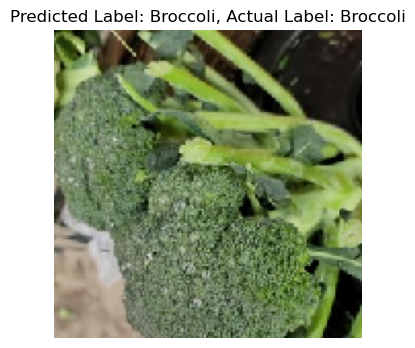

Broccoli
  分析項分類     分析項  單位   每100克含量 樣本數     標準差 每單位重含量x1 每100克含量
0  一般成分      熱量  kcal      28                   95      28
1  一般成分    修正熱量  kcal      23                   78      23
2  一般成分      水分     g    90.8   3  1.5000    307.8    90.8
3  一般成分     粗蛋白     g     3.7   3  0.7000     12.5     3.7
4  一般成分     粗脂肪     g     0.2   3  0.1000      0.7     0.2
5  一般成分    飽和脂肪     g     0.0                    0     0.0
6  一般成分      灰分     g     0.9   3  0.0000      3.1     0.9
7  一般成分  總碳水化合物     g     4.4                 14.9     4.4
8  一般成分    膳食纖維     g     3.1   3  0.9000     10.5     3.1


In [47]:
#隨機讀取測試集照片
num=random.randrange(1001,1201)
test_image_path = f"C:\\cin\\Vegetable Images\\test\\Broccoli\\{num}.jpg"

#測試模型
def generate_predictions(test_image_path, actual_label):
    
    #讀取隨機圖片
    test_img = image.load_img(test_image_path, target_size=(150, 150))
    test_img_arr = image.img_to_array(test_img)/255.0
    test_img_input = test_img_arr.reshape((1, test_img_arr.shape[0], test_img_arr.shape[1], test_img_arr.shape[2]))

    #測試模型視覺化
    predicted_label = np.argmax(model.predict(test_img_input))
    predicted_vegetable = class_map[predicted_label]
    accuracy = tf.keras.metrics.Accuracy()
    result = accuracy.result()
    print(result)
    plt.figure(figsize=(4, 4))
    plt.imshow(test_img_arr)
    plt.title("Predicted Label: {}, Actual Label: {}".format(predicted_vegetable, actual_label))
    plt.grid()
    plt.axis('off')
    plt.show()
    print(predicted_vegetable)
    print(VegetableName(predicted_vegetable))
    

generate_predictions(test_image_path, actual_label='Broccoli')

In [ ]:
generate_predictions(path, actual_label='carrot')

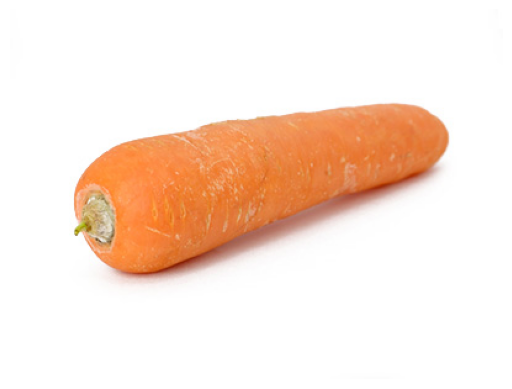

In [21]:


#從網路上抓圖下來測試
carrot="https://nabesuru.jp/images/orig_km_make02.jpg"
response=requests.get(carrot)
#取得
if response.status_code==200:
    image_data=response.content
    
    image_file = BytesIO(image_data)

    img=Image.open(image_file)
    
    mime_type, _ = mimetypes.guess_type(carrot)
    
    if mime_type is None:
        file_extension=".png"
    else:
        file_extension =mimetypes.guess_extension(mime_type) or ".png"
    
    path="C:\cin\Vegetable Images\webpic" +file_extension
    img.save(path)
    
    plt.imshow(img)
    plt.axis('off')
    plt.show()
else:
    print("failed to retrieve")
